In [1]:
from fastai.text import *
import pandas as pd
import numpy as np

In [2]:
dataset = pd.read_csv('user_data.csv')
dataset

,0
0,tok5 tok10 tok1303 tok2861 tok489 tok9780 tok9...
1,tok5 tok11 tok986 tok822 tok383 tok2834 tok156...
2,tok10 tok5 tok8 tok150 tok445 tok5575 tok9813 ...
3,tok9 tok1464 tok2239 tok1756 tok1453 tok718 to...
4,tok8 tok7 tok1 tok795 tok113 tok538 tok620 tok...
...,...
14995,tok5 tok12 tok6 tok11 tok6744 tok9338 tok522 t...
14996,tok10 tok5 tok18 tok9815 tok0 tok6 tok2239 tok...
14997,tok5 tok8 tok2 tok1336 tok9813 tok10 tok455 to...
14998,tok1 tok10 tok3 tok2079 tok4054 tok961 tok617 ...


In [3]:
dataset.columns = ['user_history']
dataset['label'] = np.array(0)
dataset

,user_history,label
0,tok5 tok10 tok1303 tok2861 tok489 tok9780 tok9...,0
1,tok5 tok11 tok986 tok822 tok383 tok2834 tok156...,0
2,tok10 tok5 tok8 tok150 tok445 tok5575 tok9813 ...,0
3,tok9 tok1464 tok2239 tok1756 tok1453 tok718 to...,0
4,tok8 tok7 tok1 tok795 tok113 tok538 tok620 tok...,0
...,...,...
14995,tok5 tok12 tok6 tok11 tok6744 tok9338 tok522 t...,0
14996,tok10 tok5 tok18 tok9815 tok0 tok6 tok2239 tok...,0
14997,tok5 tok8 tok2 tok1336 tok9813 tok10 tok455 to...,0
14998,tok1 tok10 tok3 tok2079 tok4054 tok961 tok617 ...,0


In [4]:
class CustomTokenizer(BaseTokenizer):
    def __init__(self, max_seq_len=None, **kwargs):
        self.max_seq_len = max_seq_len
    
    def tokenizer(self, t):
        token_list = t.split()
        if self.max_seq_len:
            token_list[:self.max_seq_len]
        
        return token_list + ['xxeos']
    
    def __call__(self, *args, **kwargs): 
        return self

def lowercase_everything(x):
    res = []
    for t in x:
#         print(t)
        if t.isupper() and len(t) > 1: res.append(t.lower())
        else: res.append(t)
    return res

def remove_duplicates(x):
    return list(dict.fromkeys(x))

In [5]:
with open('token_to_value.json', 'r') as f:
    vocab_dict = json.load(f)
    
vocab = Vocab(list(vocab_dict.keys()) + ['xxeos'])

In [6]:
customtokenizer = CustomTokenizer()
tokenizer = Tokenizer(tok_func = customtokenizer, pre_rules=[], post_rules=[remove_duplicates, lowercase_everything])
tokenize_processor = TokenizeProcessor(tokenizer=tokenizer, include_bos=False, include_eos=False)

numericalize_processor = NumericalizeProcessor(vocab=vocab)
transformer_processor = [tokenize_processor, numericalize_processor]

In [7]:
data_lm = (TextList.from_df(dataset, cols='user_history', processor=transformer_processor)
                .split_by_rand_pct(0.2, seed=1)
                .label_for_lm()
                .databunch(bs=16))

In [8]:
data_lm.show_batch()

idx,text
0,tok3229 tok3230 tok1183 tok3231 tok101 tok3232 tok3018 tok3233 tok11 tok4 tok3158 tok3159 tok3160 tok335 tok812 tok2178 tok40 tok41 tok42 tok43 tok44 tok45 tok46 tok47 tok48 tok49 tok50 tok51 tok52 tok53 tok54 tok55 tok6 tok3 tok137 tok907 tok2629 tok2630 tok2100 tok2631 tok2632 tok2633 tok2634 tok6836 tok6837 tok6838 tok6839 xxeos tok9 tok1464 tok2239 tok1756 tok1453 tok718 tok1667 tok6079 tok496 tok2328 tok766 tok3949 tok2016 tok8652 tok9824 tok0 tok1 tok2 tok327 tok107 tok59 tok122
1,tok4801 xxeos tok5 tok390 tok1721 tok640 tok3097 tok645 tok3098 tok567 tok27 tok507 tok868 tok236 tok524 tok649 tok80 tok3099 tok430 tok3100 tok3101 tok3102 tok3103 tok3104 tok9813 tok10 tok11 tok224 tok2797 tok2965 tok2530 tok1800 tok2431 tok8606 tok4306 tok3278 tok3511 tok773 tok4539 tok8607 tok9817 tok1 tok0 tok9 tok1437 tok5673 tok8770 tok8771 tok6793 tok8772 tok4 tok6 tok1690 tok3230 tok57 tok1562 tok7336 tok522 tok1226 tok7337 tok2030 tok1244 tok1833 tok2605 tok12 tok274 tok1948 tok5225 tok1164 tok1869
2,tok235 tok11 tok7571 tok2723 tok429 tok9813 tok0 tok3 tok795 tok1053 tok3042 tok362 tok200 tok561 tok3378 tok562 tok18 tok14 tok8755 tok9825 tok1028 tok4441 tok3567 tok6755 tok15 tok1050 tok459 tok1054 tok748 tok930 tok752 tok419 tok3069 tok1079 tok3070 tok3071 tok3072 tok3073 tok3074 tok3075 tok3076 tok1118 tok3077 xxeos tok0 tok189 tok687 tok9813 tok1 tok10 tok2 tok215 tok1709 tok85 tok699 tok184 tok168 tok208 tok3745 tok741 tok211 tok5137 tok2575 tok2525 tok1800 tok1850 tok3014 tok4193 tok4413 tok3278
3,tok383 tok97 tok2487 tok1033 tok4728 tok4955 tok522 tok274 tok2560 tok686 tok413 tok4772 tok8118 tok8119 tok5 tok1604 tok6469 tok1955 tok832 tok6282 xxeos tok10 tok4 tok2530 tok1451 tok1901 tok4997 tok1827 tok8 tok9813 tok4953 tok538 tok3667 tok2362 tok5037 tok4292 tok5038 tok5039 tok5040 tok1188 tok119 tok5041 tok6 tok0 tok1 tok3 tok245 tok246 tok247 tok248 tok249 tok250 tok251 tok252 tok253 tok254 tok255 tok256 tok257 tok258 tok259 tok260 tok261 tok262 tok263 tok264 tok265 tok266 tok267 tok55
4,tok1800 tok1579 tok1813 tok375 tok6157 tok4738 tok2723 tok6158 tok564 tok3706 tok5560 tok11 tok433 tok2025 tok429 xxeos tok10 tok5 tok8 tok16 tok11 tok113 tok3983 tok3511 tok773 tok7553 tok119 tok9813 tok7 tok2598 tok1499 tok171 tok2599 tok663 tok741 tok2600 tok2601 tok2602 xxeos tok17 tok18 tok9813 tok10 tok2743 tok4898 tok2247 tok4899 tok1380 tok1662 tok3711 tok4900 tok2630 tok4901 tok714 tok2609 tok365 tok4180 tok651 tok0 tok4 tok5 tok6 tok1236 tok189 tok4054 tok1238 tok6053 tok165 tok5555 tok4157


In [9]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=False, drop_mult=0.3)

In [10]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


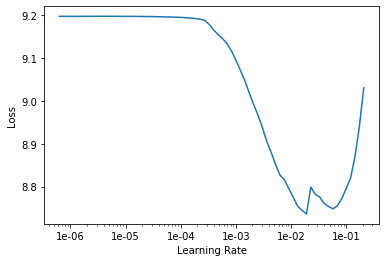

In [11]:
learn.recorder.plot(skip_end=15)

In [12]:
learn.fit_one_cycle(20, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.443477,5.017597,0.159680,03:29
1,2.433562,2.244404,0.555576,03:29
2,2.042593,1.897693,0.612153,03:29
3,1.736705,1.606770,0.670234,03:29
4,1.452355,1.378989,0.718705,03:29
5,1.280339,1.271780,0.734539,03:29
6,1.183174,1.220583,0.743146,03:29
7,1.096608,1.213706,0.744347,03:29


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


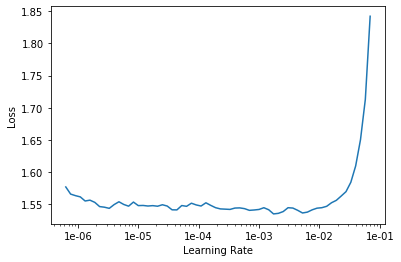

In [13]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [11]:
learn.fit_one_cycle(4, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.266251,1.335158,0.729503,03:30
1,1.227204,1.297710,0.734841,03:30
2,1.167325,1.278148,0.737423,03:30
3,1.129615,1.275830,0.737641,03:30


In [12]:
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.605754,1.494672,0.698221,03:30
1,1.252827,1.264091,0.738534,03:30


In [13]:
learn.export('models/recom_model.pkl')

In [17]:
TEXT = 'tok12 tok6 tok1629 tok2018 tok1033 tok2353 tok4229 tok5724 tok779 tok2321 tok371 tok934 tok1171 tok8114 tok9813 tok0 tok2008 tok3407 tok3534 tok9368 tok55 tok1 tok10 tok5818 tok288 tok1780 tok13 tok1631 tok540 tok5 tok7821 tok429 tok42 tok2155 tok2156 tok2157 tok1781 tok2158 tok2159 tok2160 tok2 tok7 tok3 tok8 tok356 tok126 tok86 tok34 tok1095 tok6235 tok6236 tok5 tok9813 tok0 tok14 tok1291 tok273 tok5353 tok9821 tok9 tok141 tok5716 tok1040 tok949 tok1908 tok5717 tok2859 tok5209 tok731 tok8 tok5614 tok6 tok13 tok2 tok5565 tok4750 tok1112 tok2353 tok2099 tok184 tok15 tok235 tok1832 tok33 tok635 tok329 tok5745 tok5746 tok5747 tok5748 tok5749 tok5750 tok12 tok216 tok3196 tok5425 tok2011 tok2046 tok413 tok449 tok0 tok10 tok5 tok11 tok776 tok777 tok1600 tok1851 tok4678 tok2861 tok429 tok9813 tok5912 tok12 tok2 tok696 tok460 tok606 tok3207 tok2363 tok859 tok7257 tok2479 tok77 tok3198 tok2506 tok8 tok3209 tok1208 tok452 tok7258 tok7259 tok3 tok358 tok21 tok333 tok1451 tok540 tok1171 tok1452 tok16 tok1579 tok113 tok3373 tok1891'
N_WORDS = 20
N_SENTENCES = 1

In [59]:
pred = learn.predict(TEXT, N_WORDS, temperature=0.75)[len(TEXT) + 1:].split()
new_movie_desc = []
for token in pred:
    if token == 'xxeos':
        break
    new_movie_desc.append(token)

list(dict.fromkeys(new_movie_desc))

In [60]:
new_movie_desc

['tok5',
 'tok10',
 'tok16',
 'tok8',
 'tok2',
 'tok839',
 'tok113',
 'tok113',
 'tok2161',
 'tok9619',
 'tok529',
 'tok3594',
 'tok113',
 'tok3478',
 'tok3479',
 'tok3480',
 'tok3481',
 'tok3482',
 'tok3483',
 'tok3484']